<a href="https://colab.research.google.com/github/Sanvika25/implementing-NN-using-Image-Denoising/blob/main/ann_week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/MyDrive/ANN"))

# Any results you write to the current directory are saved as output.

['sampleSubmission.csv.zip', 'train', 'test', 'train_cleaned']


In [ ]:
!pip install python-resize-image

In [ ]:
import cv2
import os
import numpy as np
from PIL import Image
from resizeimage import resizeimage

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename == "train":
            continue
        if filename == "test":
            continue
        if filename == "train_cleaned":
            continue
        img = cv2.imread(os.path.join(folder,filename))
        img = np.array(img)
        s = img.shape
        s = np.array(s)
        if  s[0] == 258:
            img1 = Image.open(os.path.join(folder,filename))
            new1 = resizeimage.resize_contain(img1, [540, 420, 3])
            new1 = np.array(new1, dtype='uint8')
            images.append(new1)
        else:
            img1 = Image.open(os.path.join(folder,filename))
            images.append(img)
    return images

train = load_images_from_folder("/content/drive/MyDrive/ANN/train/train/train")
test = load_images_from_folder("/content/drive/MyDrive/ANN/test/test/test")
train_cleaned = load_images_from_folder("/content/drive/MyDrive/ANN/train_cleaned/train_cleaned/train_cleaned")

In [ ]:
import cv2
import numpy as np

# Define the target shape
target_shape = (420, 540)

# Function to resize and preprocess images
def preprocess_image(img, target_shape):
    # Ensure the image is in RGB format
    if img.shape[2] == 4:  # If it has 4 channels (RGBA)
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Resize the image while maintaining its aspect ratio
    width, height = target_shape
    img_height, img_width, _ = img.shape
    aspect_ratio = img_width / img_height

    if aspect_ratio > width / height:
        new_width = width
        new_height = int(width / aspect_ratio)
    else:
        new_height = height
        new_width = int(height * aspect_ratio)

    resized_img = cv2.resize(img, (new_width, new_height))

    # Create a blank canvas of the target shape and place the resized image in the center
    canvas = np.zeros((height, width, 3), dtype=np.uint8)
    y_offset = (height - new_height) // 2
    x_offset = (width - new_width) // 2
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width, :] = resized_img

    return canvas

# Preprocess and convert to NumPy arrays
resized_train = [preprocess_image(img, target_shape) for img in train]
resized_test = [preprocess_image(img, target_shape) for img in test]
resized_train_cleaned = [preprocess_image(img, target_shape) for img in train_cleaned]

train_array = np.array(resized_train, dtype='float32') / 255
test_array = np.array(resized_test, dtype='float32') / 255
train_cleaned_array = np.array(resized_train_cleaned, dtype='float32') / 255

In [ ]:
train_array.shape

(144, 540, 420, 3)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import SpatialDropout1D, Conv2D, MaxPooling2D, UpSampling2D
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(540, 420, 3),))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.summary()

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 540, 420, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 270, 210, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 270, 210, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 135, 105, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 135, 105, 32)      9248      
                                                                 
 up_sampling2d (UpSampling2  (None, 270, 210, 32)      0

In [ ]:
model.fit(train_array, train_cleaned_array, epochs=250, batch_size=52, shuffle=True, validation_data=(train_array, train_cleaned_array))

Epoch 1/250
3/3 [==============================] - 166s 51s/step - loss: 0.6771 - accuracy: 0.1565 - val_loss: 0.6770 - val_accuracy: 0.0267
Epoch 2/250
3/3 [==============================] - 139s 51s/step - loss: 0.6769 - accuracy: 0.0267 - val_loss: 0.6768 - val_accuracy: 0.0266
Epoch 3/250
3/3 [==============================] - 126s 45s/step - loss: 0.6767 - accuracy: 0.0266 - val_loss: 0.6766 - val_accuracy: 0.0266
Epoch 4/250
3/3 [==============================] - 137s 51s/step - loss: 0.6766 - accuracy: 0.0266 - val_loss: 0.6764 - val_accuracy: 0.0265
Epoch 5/250
3/3 [==============================] - 137s 51s/step - loss: 0.6764 - accuracy: 0.0264 - val_loss: 0.6763 - val_accuracy: 0.0259
Epoch 6/250
3/3 [==============================] - 137s 51s/step - loss: 0.6762 - accuracy: 0.0259 - val_loss: 0.6761 - val_accuracy: 0.0258
Epoch 7/250
3/3 [==============================] - 137s 51s/step - loss: 0.6760 - accuracy: 0.0258 - val_loss: 0.6759 - val_accuracy: 0.0258
Epoch 8/250
1

In [ ]:
y_hat = model.predict(test_array)

3/3 [==============================] - 22s 5s/step


In [ ]:
y_hat = np.array(y_hat)
print(y_hat.shape)

(72, 540, 420, 3)


<ipython-input-35-1541f4f8e783>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


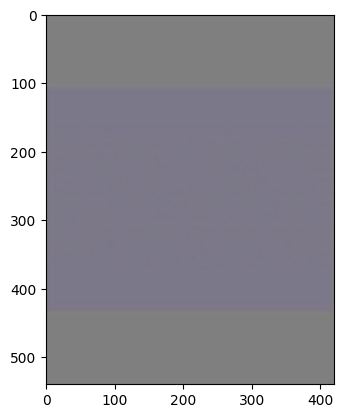

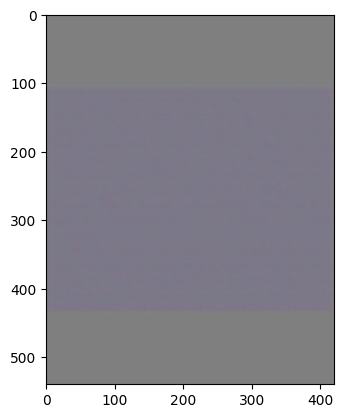

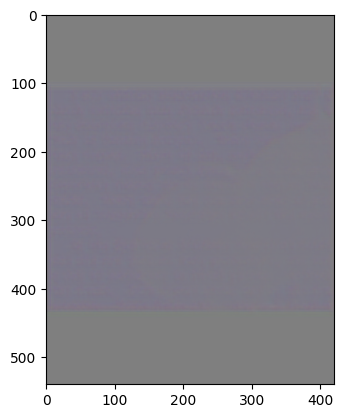

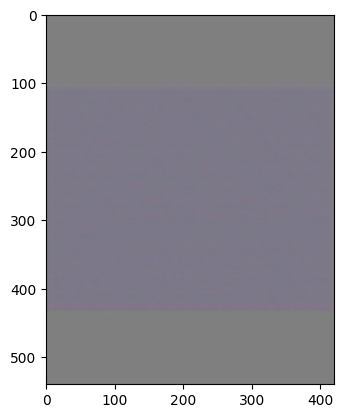

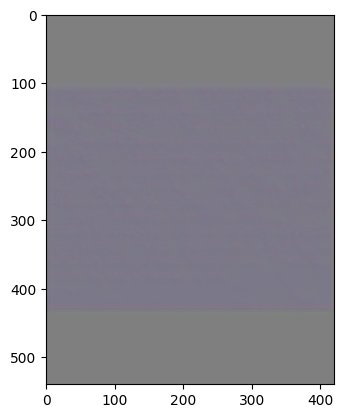

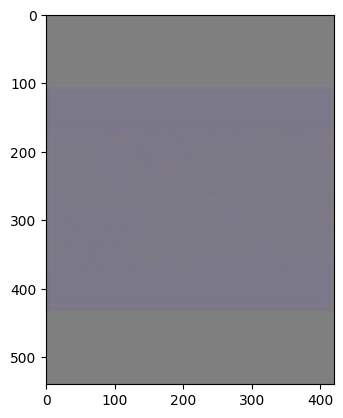

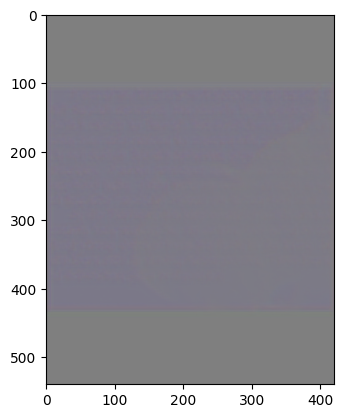

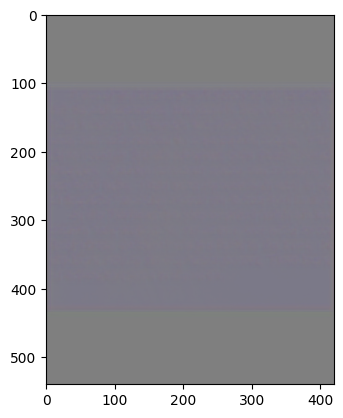

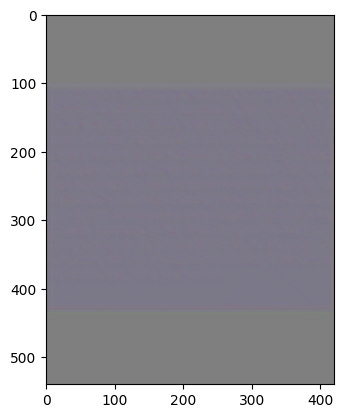

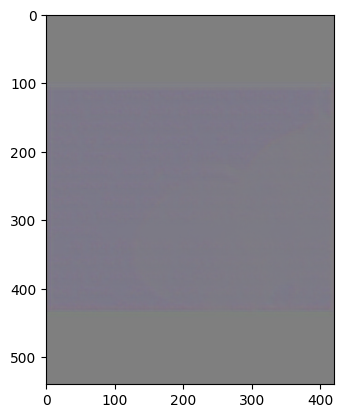

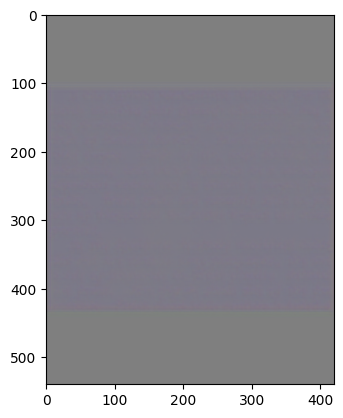

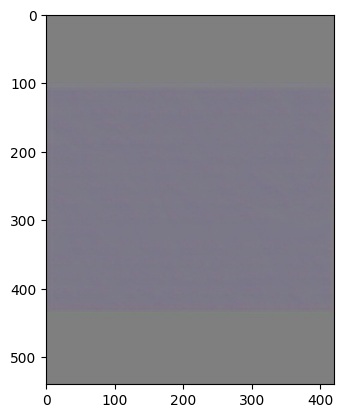

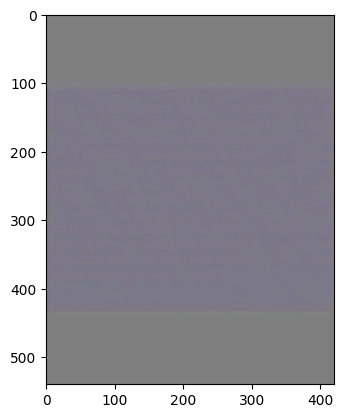

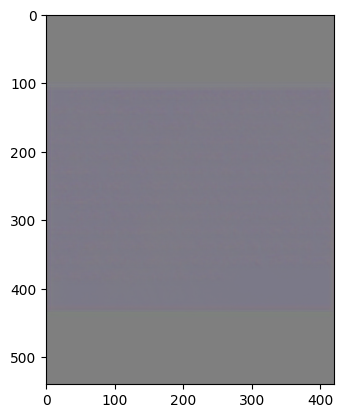

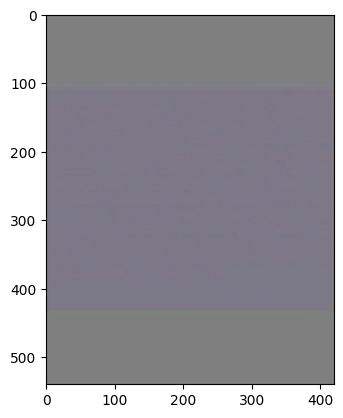

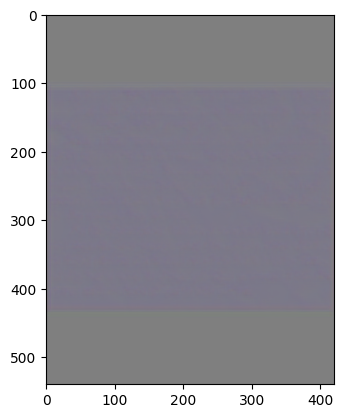

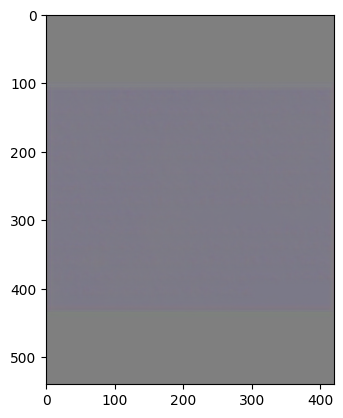

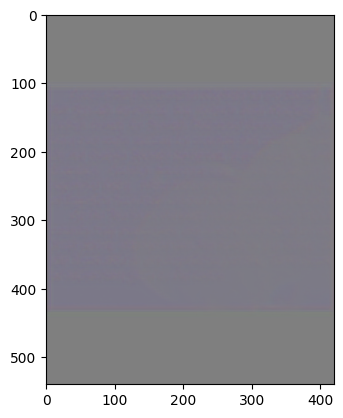

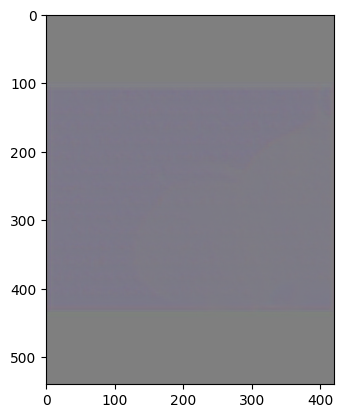

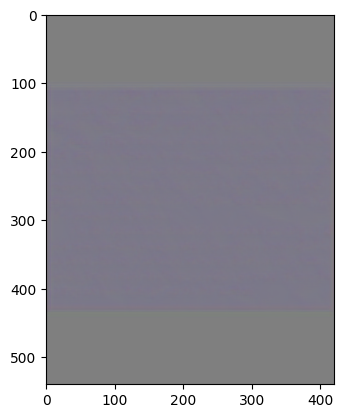

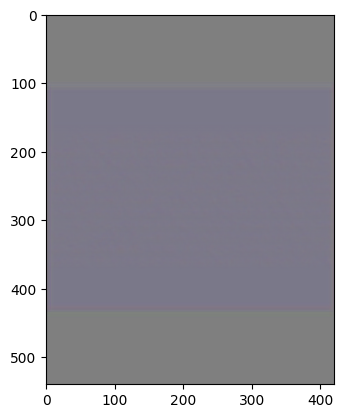

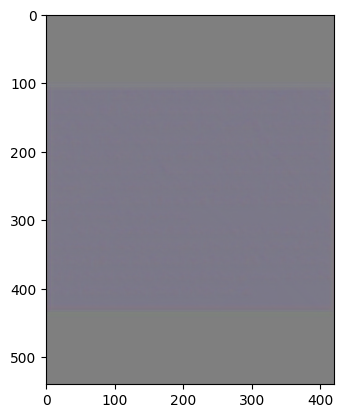

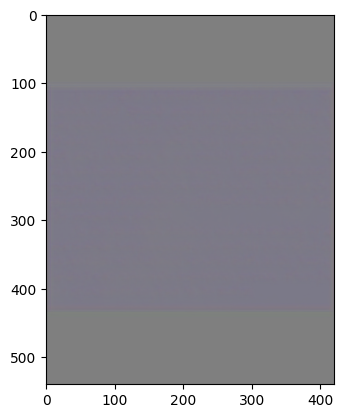

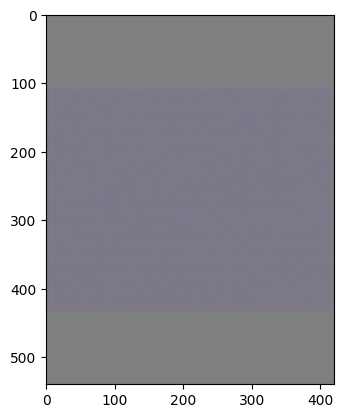

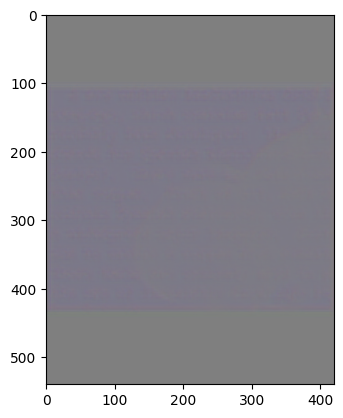

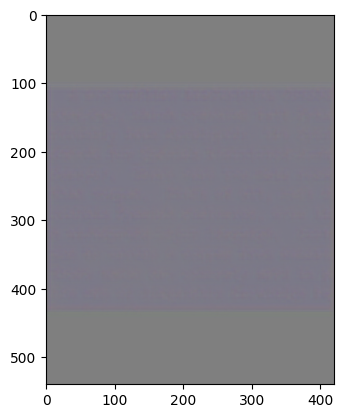

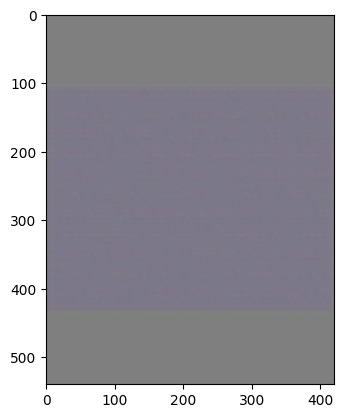

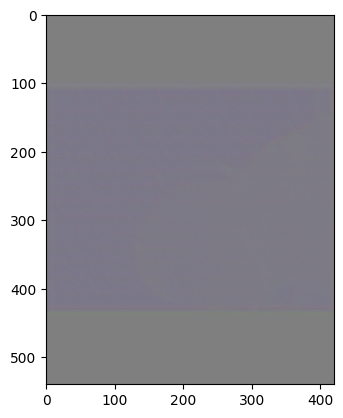

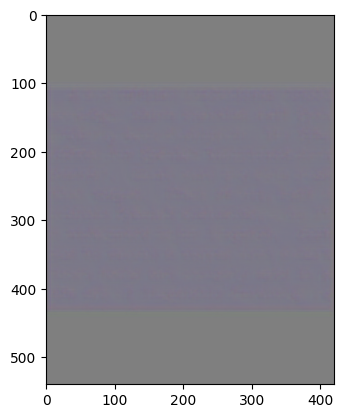

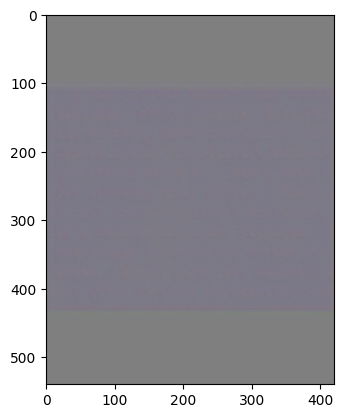

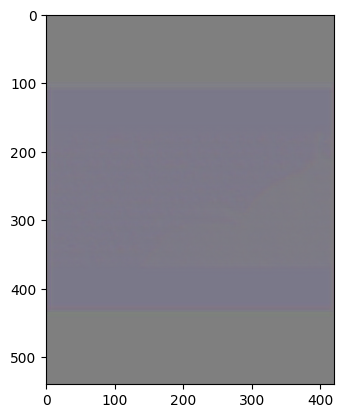

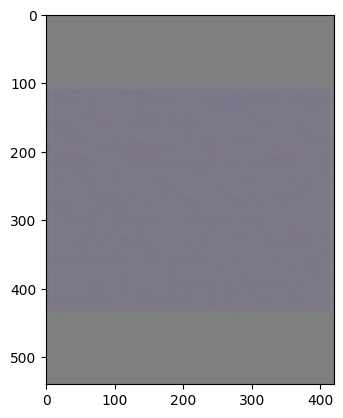

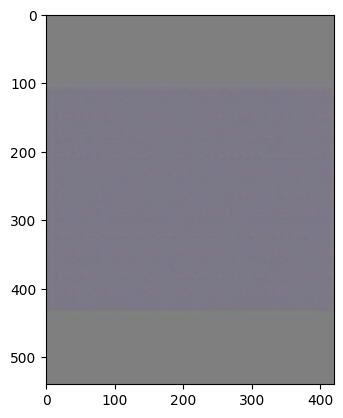

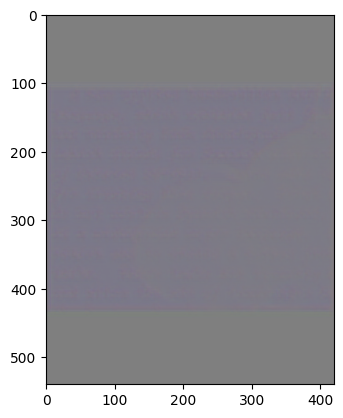

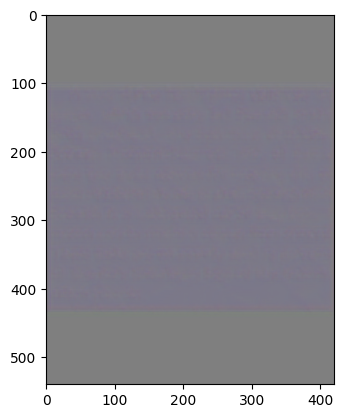

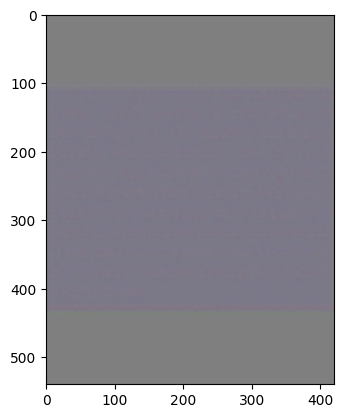

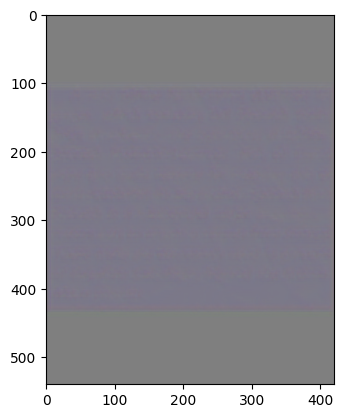

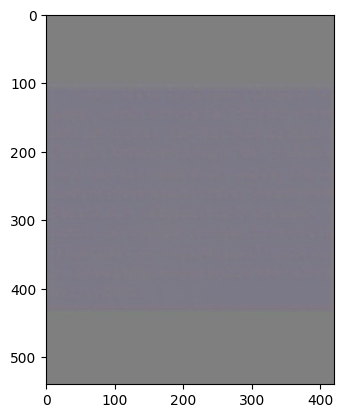

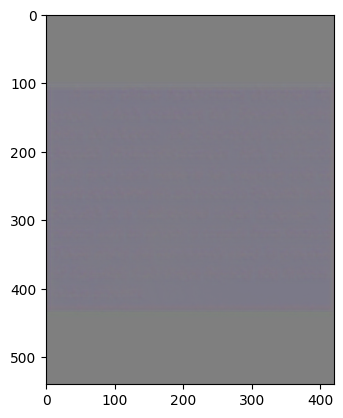

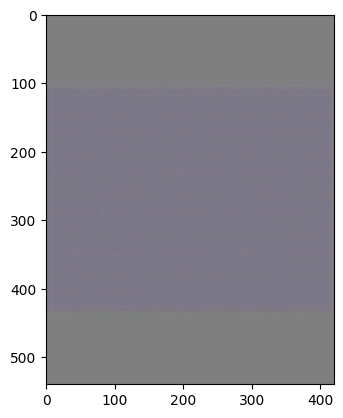

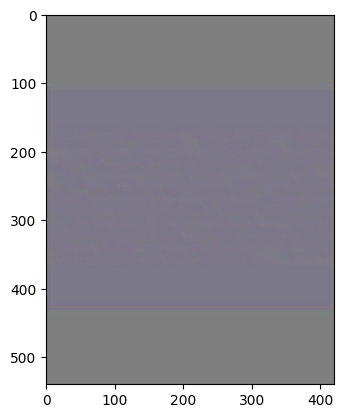

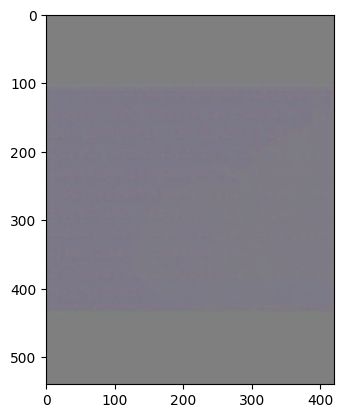

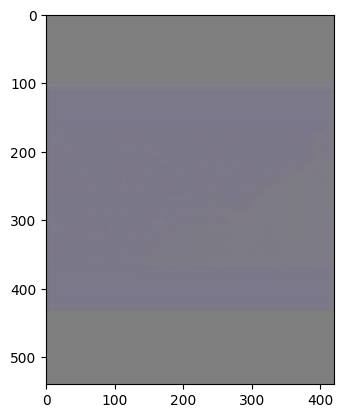

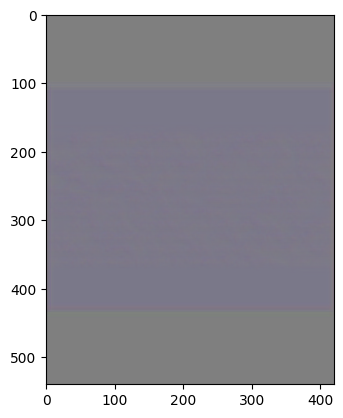

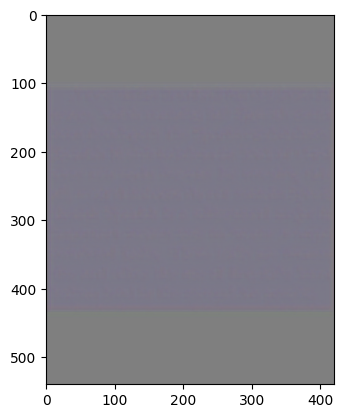

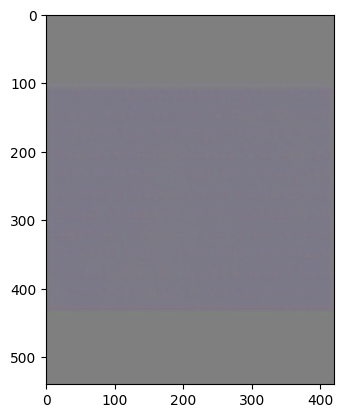

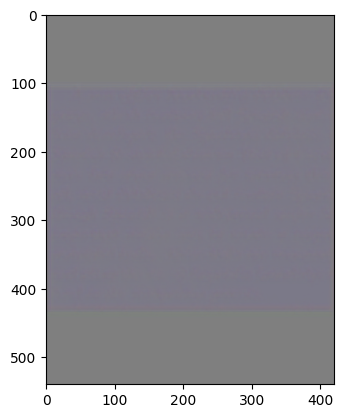

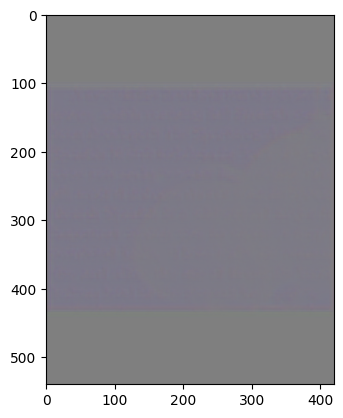

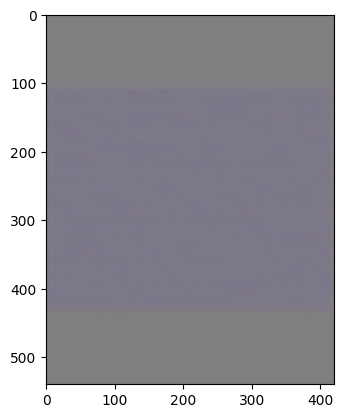

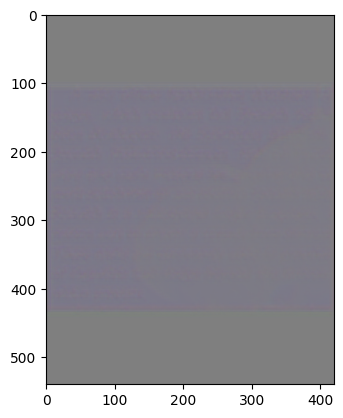

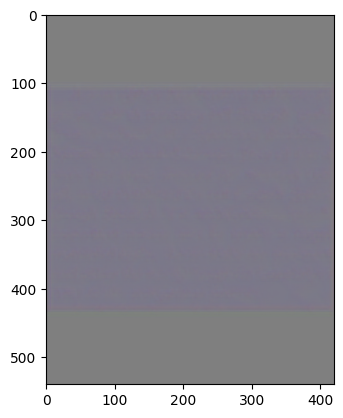

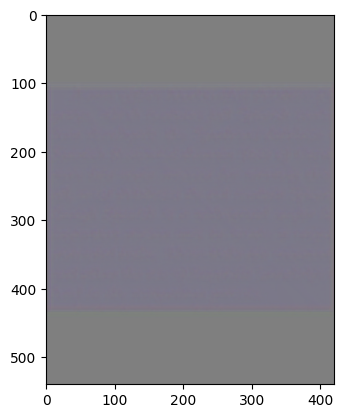

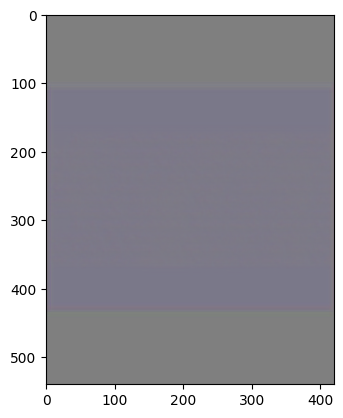

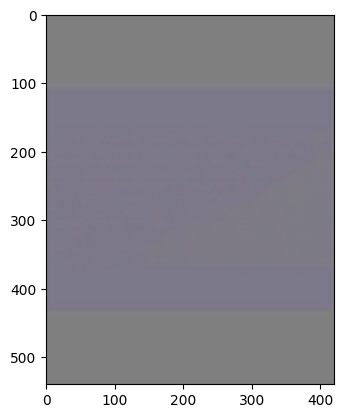

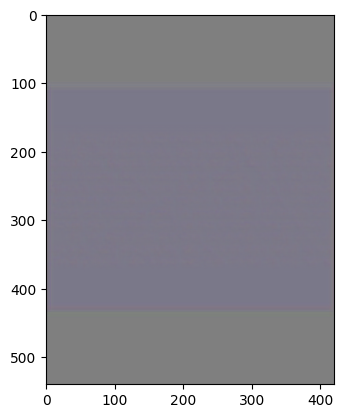

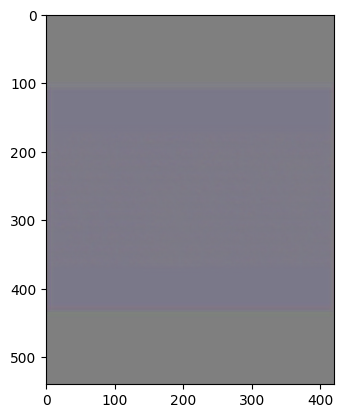

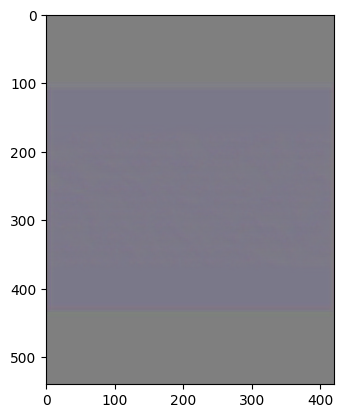

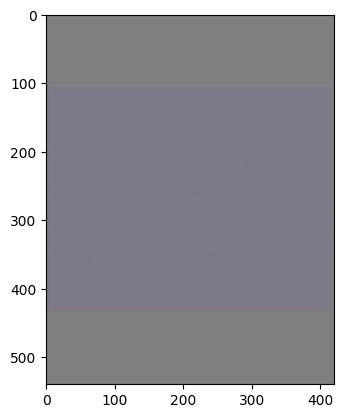

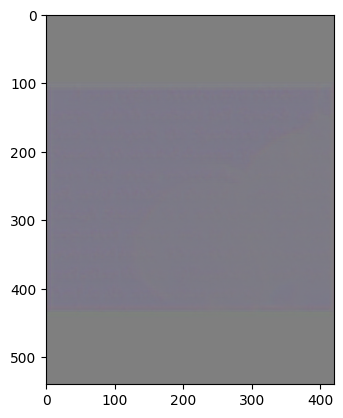

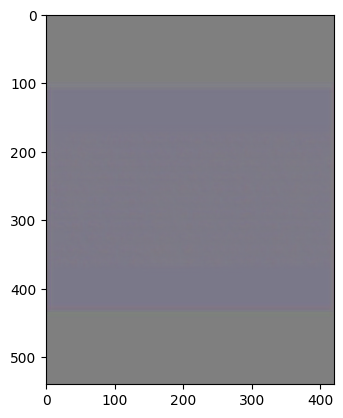

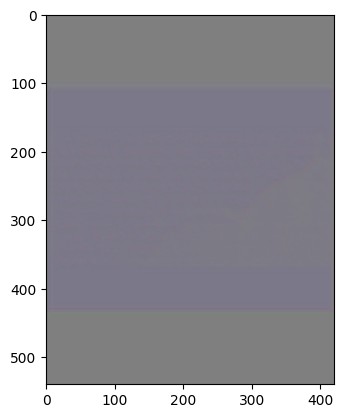

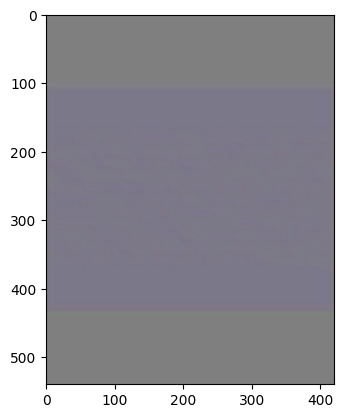

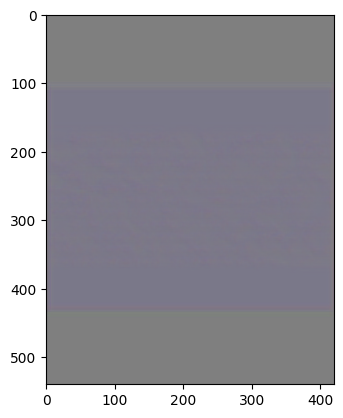

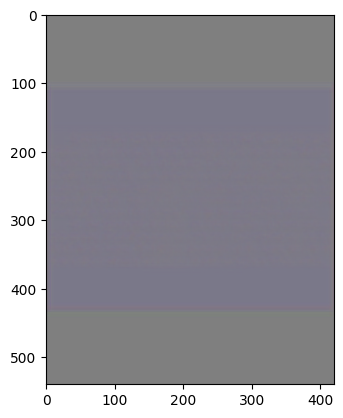

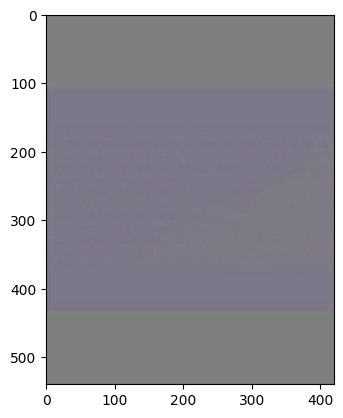

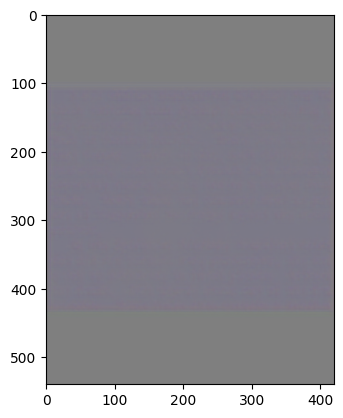

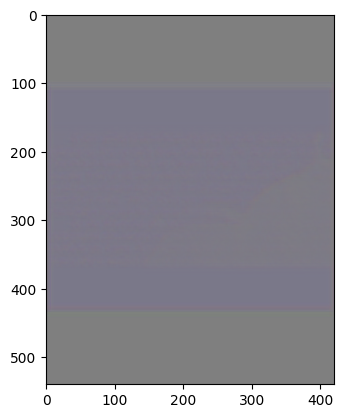

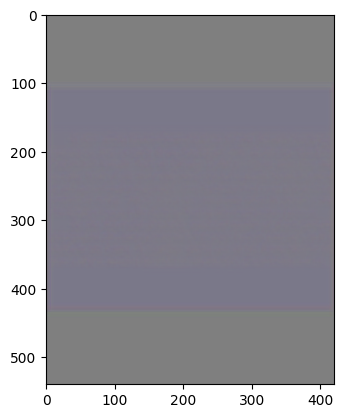

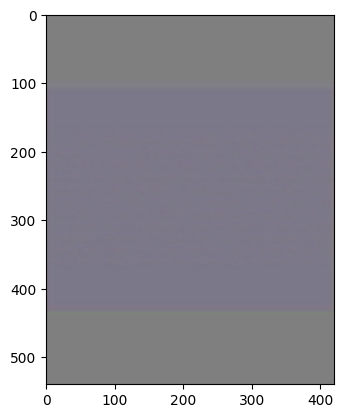

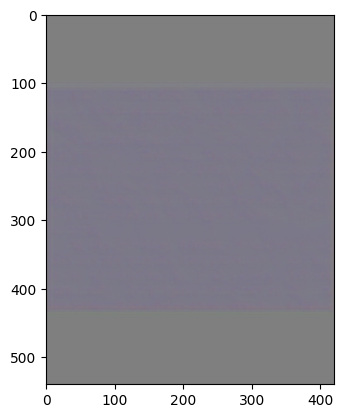

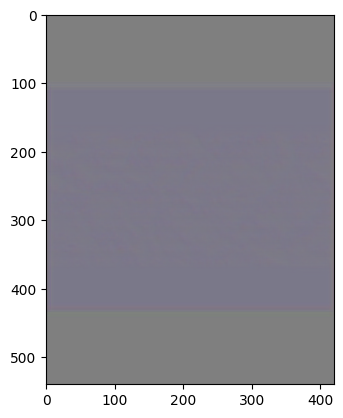

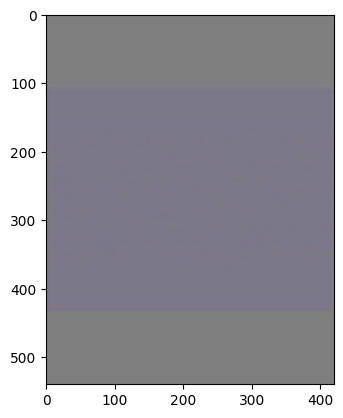

In [ ]:
import matplotlib.pyplot as plt
for ima in y_hat:
    plt.figure()
    plt.imshow(ima)